<a href="https://colab.research.google.com/github/Aditi0255/Brain-Tumor-Detection/blob/main/BT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle



In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aditi0255","key":"be28c2e51e60f14eb9c04ad7d4797555"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

 84% 73.0M/86.8M [00:00<00:00, 187MB/s]
100% 86.8M/86.8M [00:00<00:00, 183MB/s]


In [7]:
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.9 MB/s 


In [8]:
!unzip brain-tumor-classification-mri.zip

Archive:  brain-tumor-classification-mri.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor/image(25).jpg  
  infl

In [9]:
!pip install pymatreader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import io
import os
import pathlib
import matplotlib.pyplot as plt
from pymatreader import read_mat
import cv2
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
import efficientnet.keras as efn


In [11]:
types = ['glioma_tumor','meningioma_tumor','pituitary_tumor','no_tumor']
X= []
Y= []
image_size = 150
for typ in types:
    route= os.path.join('/content/Training',typ)
    for img in tqdm(os.listdir(route)):
        img1 = cv2.imread(os.path.join(route,img))
        img1 = cv2.resize(img1,(image_size, image_size))
        X.append(img1)
        Y.append(typ)
for typ in types:
    route= os.path.join('/content/Testing',typ)
    for img in tqdm(os.listdir(route)):
        img1 = cv2.imread(os.path.join(route,img))
        img1 = cv2.resize(img1,(image_size, image_size))
        X.append(img1)
        Y.append(typ)      

        
X = np.array(X)
Y = np.array(Y)

100%|██████████| 105/105 [00:00<00:00, 316.41it/s]


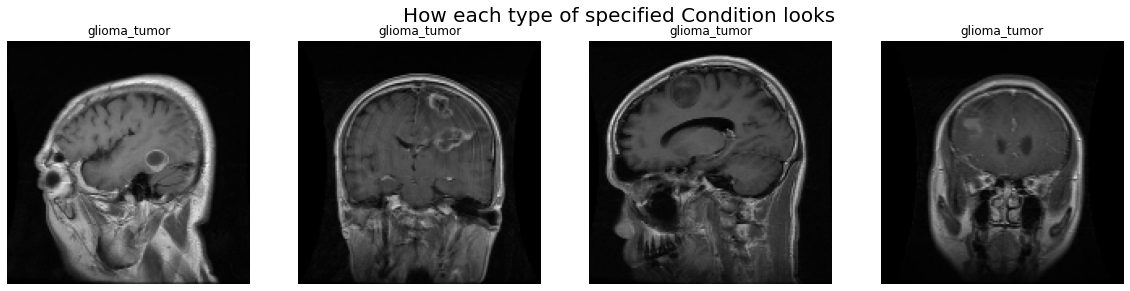

In [12]:
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='How each type of specified Condition looks',size=20,
            color='black',y=0.6,x=0.4,alpha=1)
var=0
for typ in types:
    no=0
    for var in range(0,4):
        if Y[no]==typ:
            ax[var].imshow(X[no])
            ax[var].set_title(Y[no])
            ax[var].axis('off')
            
        no+=1

In [13]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.3,shuffle=True,random_state=42)
temp = []
for y in Y_train:
    temp.append(types.index(y))
Y_train = temp
Y_train = tf.keras.utils.to_categorical(Y_train)


temp = []
for y in Y_test:
    temp.append(types.index(y))
Y_test = temp
Y_test = tf.keras.utils.to_categorical(Y_test)

In [14]:
model = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
eff = model.output
eff = tf.keras.layers.GlobalAveragePooling2D()(eff)
eff = tf.keras.layers.Dropout(rate=0.5)(eff)
eff = tf.keras.layers.Dense(4,activation='softmax')(eff)
eff = tf.keras.models.Model(inputs=model.input, outputs = eff)

16719872/16705208 [==============================] - 0s 0us/step


In [15]:
eff.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
tb = TensorBoard(log_dir = 'logs')
cp = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
red = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)


In [16]:
train = eff.fit(X_train,Y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tb,cp,red])

Epoch 1/12
65/65 [==============================] - ETA: 0s - loss: 0.5119 - accuracy: 0.8107
Epoch 1: val_accuracy improved from -inf to 0.84279, saving model to effnet.h5
65/65 [==============================] - 287s 4s/step - loss: 0.5119 - accuracy: 0.8107 - val_loss: 0.4119 - val_accuracy: 0.8428 - lr: 0.0010
Epoch 2/12
65/65 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.9358
Epoch 2: val_accuracy did not improve from 0.84279
65/65 [==============================] - 312s 5s/step - loss: 0.1949 - accuracy: 0.9358 - val_loss: 0.5869 - val_accuracy: 0.7860 - lr: 0.0010
Epoch 3/12
65/65 [==============================] - ETA: 0s - loss: 0.1516 - accuracy: 0.9479
Epoch 3: val_accuracy improved from 0.84279 to 0.85590, saving model to effnet.h5
65/65 [==============================] - 335s 5s/step - loss: 0.1516 - accuracy: 0.9479 - val_loss: 0.4936 - val_accuracy: 0.8559 - lr: 0.0010
Epoch 4/12
65/65 [==============================] - ETA: 0s - loss: 0.1418 - 

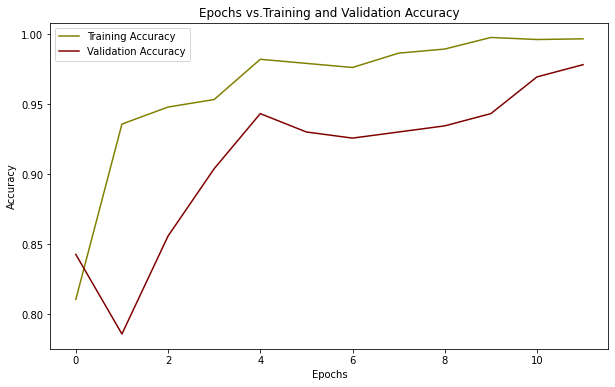

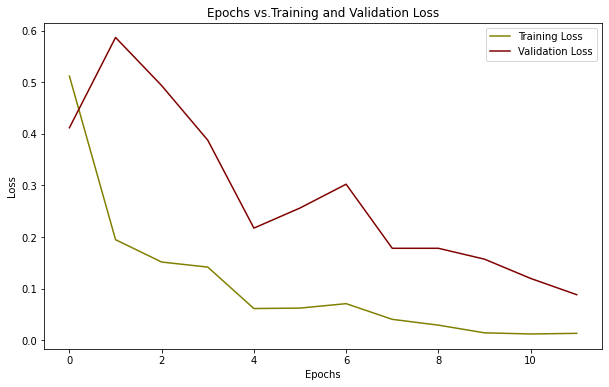

In [27]:
filterwarnings('ignore')

epochs = [epoch for epoch in range(12)]
acc = train.history['accuracy']
loss = train.history['loss']
accv = train.history['val_accuracy']
lossv = train.history['val_loss']
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, color='olive', label='Training Accuracy')
plt.plot(epochs, accv, color='maroon', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Epochs vs.Training and Validation Accuracy')
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, color='olive', label='Training Loss')
plt.plot(epochs, lossv, color='maroon', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Epochs vs.Training and Validation Loss')
plt.legend()
plt.show()



In [30]:
prdc = eff.predict(X_test)
prdc = np.argmax(prdc,axis=1)
Y_test1 = np.argmax(Y_test,axis=1)
print(classification_report(Y_test1,prdc))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       307
           1       0.96      0.90      0.93       283
           2       0.98      1.00      0.99       243
           3       0.96      0.98      0.97       147

    accuracy                           0.95       980
   macro avg       0.96      0.96      0.96       980
weighted avg       0.95      0.95      0.95       980



In [90]:
cred = ['lightcoral','lightsalmon','pink','lavender','antiquewhite']

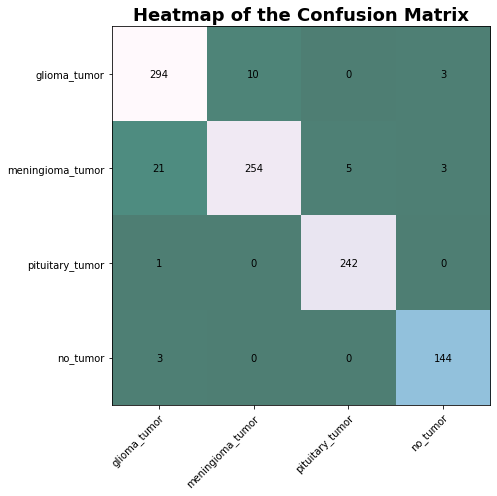

In [94]:
conf=confusion_matrix(Y_test1,prdc)
fig, ax = plt.subplots(1,1,figsize=(14,7))
im = ax.imshow(conf,cmap="PuBuGn_r",alpha=0.7)

ax.set_xticks(np.arange(len(types)))
ax.set_xticklabels(types)
ax.set_yticks(np.arange(len(types)))
ax.set_yticklabels(types)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(4):
    for j in range(4):
        text = ax.text(j, i, conf[i, j],
                       ha="center", va="center", color="black")
        
        
        

ax.set_title('Heatmap of the Confusion Matrix',size=18,fontweight='bold')

fig.tight_layout()
plt.show()